<h3> Importing important libraries </h3>

In [1]:
#python packages 
import requests
import warnings
from json import dumps,loads
import signal
import time
from datetime import datetime
import gc

#data manipulation and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#data preparation and real-time processing
from kafka import KafkaProducer, KafkaConsumer
from ksql import KSQLAPI
from kafka import KafkaAdminClient

#ml modeling
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

<h3> Data Collection</h3>

<h4> Functions Definition </h4>

In [2]:
def _get_duplicates(df):
    duplicate = df[df.duplicated()]
    if not len(duplicate):
        return "-------No Duplicates---------"
    else:
        print(f"Total Duplicate Row: {duplicate.shape[0]}")
        print("Duplicate Values are(Showing on top 10): ")
        return duplicate.head()

<h5> Loading Data from Excel </h5>

In [3]:
rawData = pd.read_excel('Motor_Insurance.xlsx')

<h5> Using head() function to display 5 rows </h5>

In [4]:
rawData.head(5)

,SUBMISSION_DATE,SUBMISSION_ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME_TYPE,CREDIT_SCORE,VEHICLE_OWNERS,VEHICLE_YEAR,MARITAL_STATUS,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,PENDING_DUES,PAST_ACCIDENTS,OUTCOME
0,1994-10-01,569520,65+,female,majority,0-9y,high school,upper class,62.90,1,after 2015,0,1,10238,12000.0,sedan,0,0,0,Denied Quote
1,1994-10-02,750365,16-25,male,majority,0-9y,none,poverty,35.78,0,before 2015,0,0,10238,16000.0,sedan,0,0,0,Considered for Quote
2,1994-10-03,199901,16-25,female,majority,0-9y,high school,working class,49.31,1,before 2015,0,0,10238,11000.0,sedan,0,0,0,Denied Quote
3,1994-10-04,478866,16-25,male,majority,0-9y,university,working class,20.60,1,before 2015,0,1,32765,11000.0,sedan,0,0,0,Denied Quote
4,1994-10-05,731664,26-39,male,majority,10-19y,none,working class,38.84,1,before 2015,0,0,32765,12000.0,sedan,2,0,1,Considered for Quote


<h5> Using info() function to display column count and data type </h5>

In [5]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SUBMISSION_DATE      10000 non-null  datetime64[ns]
 1   SUBMISSION_ID        10000 non-null  int64         
 2   AGE                  10000 non-null  object        
 3   GENDER               10000 non-null  object        
 4   RACE                 10000 non-null  object        
 5   DRIVING_EXPERIENCE   10000 non-null  object        
 6   EDUCATION            10000 non-null  object        
 7   INCOME_TYPE          10000 non-null  object        
 8   CREDIT_SCORE         9018 non-null   float64       
 9   VEHICLE_OWNERS       10000 non-null  int64         
 10  VEHICLE_YEAR         10000 non-null  object        
 11  MARITAL_STATUS       10000 non-null  int64         
 12  CHILDREN             10000 non-null  int64         
 13  POSTAL_CODE          10000 non-n

<h5> Using describe() function to describe the numerical data </h5>

In [6]:
rawData.describe(include=[np.number],datetime_is_numeric=True).T

,count,mean,std,min,25%,50%,75%,max
SUBMISSION_ID,10000.0,500521.906800,290030.768758,101.00,249638.5000,501777.000000,753974.50,999976.00
CREDIT_SCORE,9018.0,51.581273,13.768834,5.34,41.7225,52.505000,61.83,96.08
VEHICLE_OWNERS,10000.0,0.697000,0.459578,0.00,0.0000,1.000000,1.00,1.00
MARITAL_STATUS,10000.0,0.498200,0.500022,0.00,0.0000,0.000000,1.00,1.00
CHILDREN,10000.0,0.688800,0.463008,0.00,0.0000,1.000000,1.00,1.00
POSTAL_CODE,10000.0,19864.548400,18915.613855,10238.00,10238.0000,10238.000000,32765.00,92101.00
ANNUAL_MILEAGE,10000.0,11697.003207,2680.167384,2000.00,10000.0000,11697.003207,13000.00,22000.00
SPEEDING_VIOLATIONS,10000.0,1.482900,2.241966,0.00,0.0000,0.000000,2.00,22.00
PENDING_DUES,10000.0,0.239200,0.554990,0.00,0.0000,0.000000,0.00,6.00
PAST_ACCIDENTS,10000.0,1.056300,1.652454,0.00,0.0000,0.000000,2.00,15.00


<h5> Using describe() function to describe the categorical data </h5>

In [7]:
rawData.describe(exclude=[np.number]).T

/var/folders/7m/yw9rgpvx64jc0f1qj33b0xn80000gn/T/ipykernel_65407/2083080772.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  rawData.describe(exclude=[np.number]).T


,count,unique,top,freq,first,last
SUBMISSION_DATE,10000,10000,1994-10-01 00:00:00,1,1994-10-01,2022-02-15
AGE,10000,4,26-39,3063,NaT,NaT
GENDER,10000,2,female,5010,NaT,NaT
RACE,10000,2,majority,9012,NaT,NaT
DRIVING_EXPERIENCE,10000,4,0-9y,3530,NaT,NaT
EDUCATION,10000,3,high school,4157,NaT,NaT
INCOME_TYPE,10000,4,upper class,4336,NaT,NaT
VEHICLE_YEAR,10000,2,before 2015,6967,NaT,NaT
VEHICLE_TYPE,10000,2,sedan,9523,NaT,NaT
OUTCOME,10000,3,Denied Quote,5878,NaT,NaT


<h5> Checking for duplicates in the data </h5>

In [8]:
_get_duplicates(rawData)

'-------No Duplicates---------'

<h5> Checking for null values in the data </h5>

In [9]:
rawData.isnull().sum()

SUBMISSION_DATE          0
SUBMISSION_ID            0
AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME_TYPE              0
CREDIT_SCORE           982
VEHICLE_OWNERS           0
VEHICLE_YEAR             0
MARITAL_STATUS           0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE           0
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
PENDING_DUES             0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

<h3> Exploratory Data Analysis</h3>

<h4> Functions Definition </h4>

In [10]:
def get_features_for_upsample(df,feature_name,flag=False):
    _distribution = df[feature_name].value_counts()*100/df.shape[0]
    if flag:
        fig = plt.figure(figsize=(10, 5))
        ax = sns.countplot(data=df,x=feature_name)
        plt.xticks(rotation=45)
        for p in ax.patches:
            ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
        plt.show()
    return _distribution

In [11]:
def up_sample_training_dataset(data,feature):
    _majority_val = get_features_for_upsample(data,feature).index[0]
    _total_features = len(get_features_for_upsample(data,feature))
    df_majority = data[(data[feature]==_majority_val)]
    _temp_df = pd.DataFrame()
    for _i in range(1,_total_features):
        df_minority = data[data[feature]==get_features_for_upsample(data,feature).index[_i]] 
        df_minority_upsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples= df_majority.shape[0], 
                                 random_state=42) 
        _temp_df = pd.concat([df_minority_upsampled, _temp_df],ignore_index=True)
    return pd.concat([_temp_df, df_majority],ignore_index=True)

In [12]:
def get_feature_distribution(df,feature_name, chart_type, flag=False):
    if flag and chart_type == 'bar':
        print("\n\nTabular representation:\n")
        table_values = pd.crosstab(df[feature_name],df.OUTCOME)
        print(table_values)
        print("\n\n Graphical representation:")
        ax = table_values.plot(kind="bar",figsize=(10,4))
        plt.title('Data Distribution')
        plt.xlabel(feature_name)
        plt.ylabel('FREQUENCY')
        plt.show()
        
    elif chart_type == 'count' : 
        distribution = df[feature_name].value_counts()*100/df.shape[0]
        fig = plt.figure(figsize=(10, 5))
        ax = sns.countplot(data=df,x=feature_name)
        plt.xticks(rotation=45)
        for p in ax.patches:
            ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
        plt.title('DATA DISTRIBUTION')
        plt.xlabel(feature_name)
        plt.ylabel('FREQUENCY')
        plt.show()
    
    elif chart_type == 'box':
        fig = plt.figure(figsize=(10, 5))
        ax = sns.boxplot(data=df, x='OUTCOME', y=feature_name)
        plt.title('OUTLIER ANALYSIS')
        ax.set_xlabel('OUTCOME', labelpad = 15)
        ax.set_ylabel(feature_name, labelpad = 15)
        
        
    else:
        fig, ax = plt.subplots(figsize = (10,6))
        sns.histplot(
            df[feature_name],
            kde = True,
            color = '#14294F'
        )
        ax.set_xlabel(feature_name, labelpad = 15)
        ax.set_ylabel('FREQUENCY', labelpad = 15)
        plt.title('DATA DISTRIBUTION')

<h4> Feature Distribution </h4>



Tabular representation:

OUTCOME  Considered for Quote  Denied Quote  Need Evaluation
AGE                                                         
16-25                    1448           568                0
26-39                    1032          1920              111
40-64                     457          2068              406
65+                       196          1322              472


 Graphical representation:


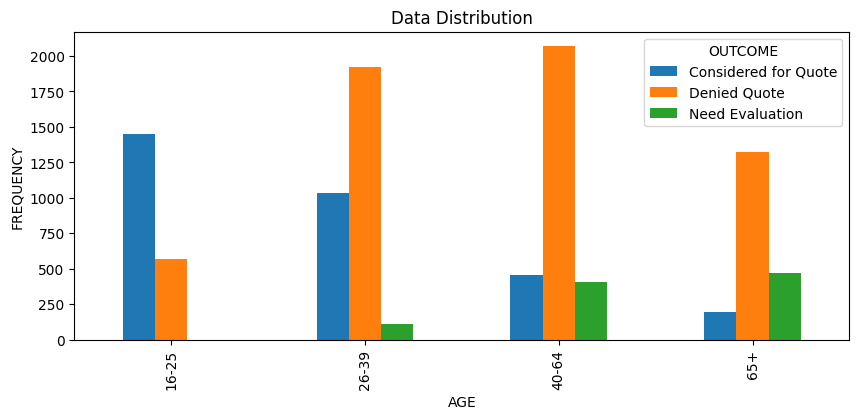

In [13]:
get_feature_distribution(rawData, 'AGE', 'bar', True)



Tabular representation:

OUTCOME  Considered for Quote  Denied Quote  Need Evaluation
GENDER                                                      
female                   1321          3360              329
male                     1812          2518              660


 Graphical representation:


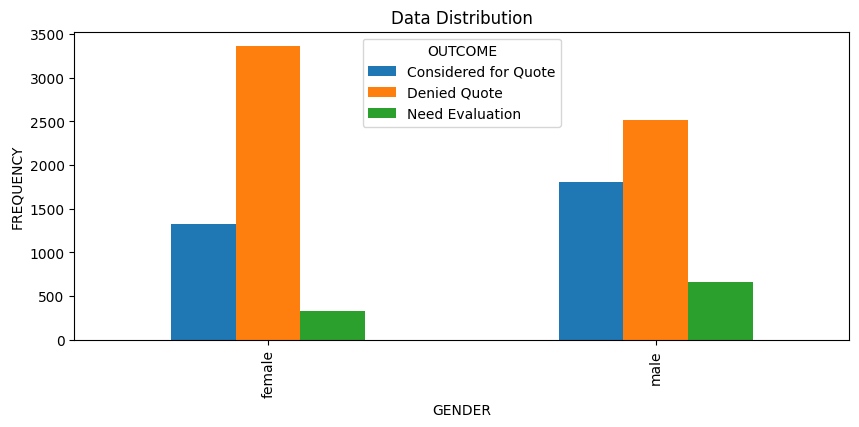

In [14]:
get_feature_distribution(rawData, 'GENDER', 'bar', True)



Tabular representation:

OUTCOME   Considered for Quote  Denied Quote  Need Evaluation
RACE                                                         
majority                  2812          5315              885
minority                   321           563              104


 Graphical representation:


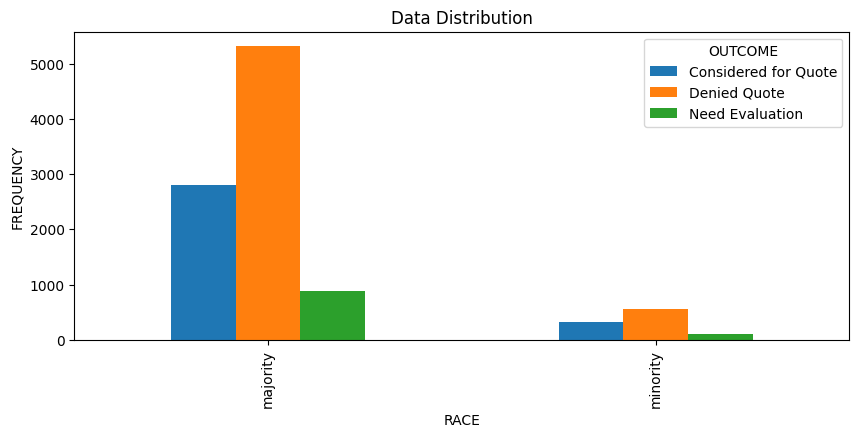

In [15]:
get_feature_distribution(rawData, 'RACE', 'bar', True)



Tabular representation:

OUTCOME             Considered for Quote  Denied Quote  Need Evaluation
DRIVING_EXPERIENCE                                                     
0-9y                                2217          1313                0
10-19y                               787          2348              164
20-29y                               109          1567              443
30y+                                  20           650              382


 Graphical representation:


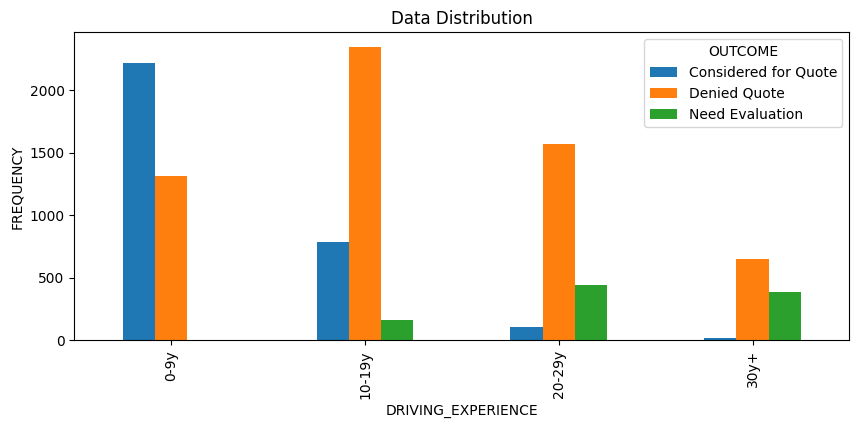

In [16]:
get_feature_distribution(rawData, 'DRIVING_EXPERIENCE', 'bar', True)



Tabular representation:

OUTCOME      Considered for Quote  Denied Quote  Need Evaluation
EDUCATION                                                       
high school                  1344          2429              384
none                          903           907              105
university                    886          2542              500


 Graphical representation:


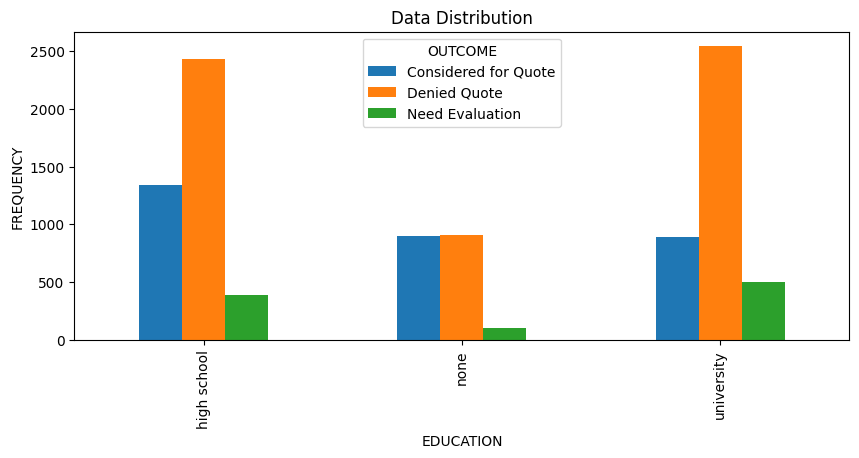

In [17]:
get_feature_distribution(rawData, 'EDUCATION', 'bar', True)



Tabular representation:

OUTCOME        Considered for Quote  Denied Quote  Need Evaluation
INCOME_TYPE                                                       
middle class                    592          1373              173
poverty                        1186           600               28
upper class                     579          3055              702
working class                   776           850               86


 Graphical representation:


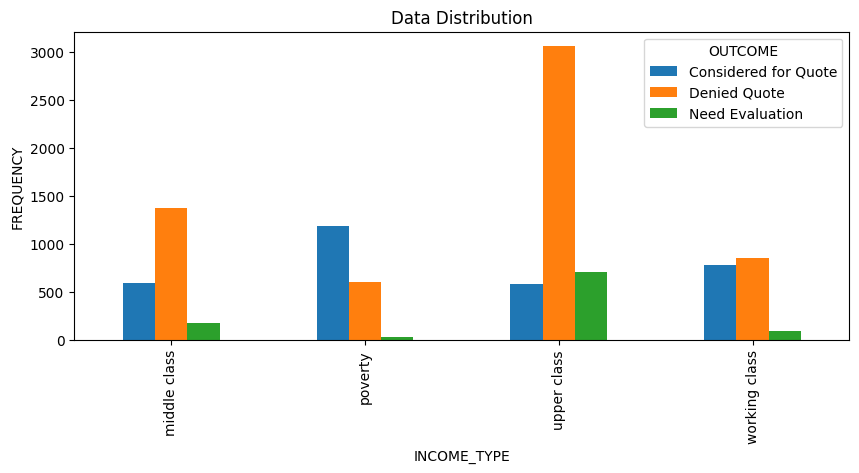

In [18]:
get_feature_distribution(rawData, 'INCOME_TYPE', 'bar', True)

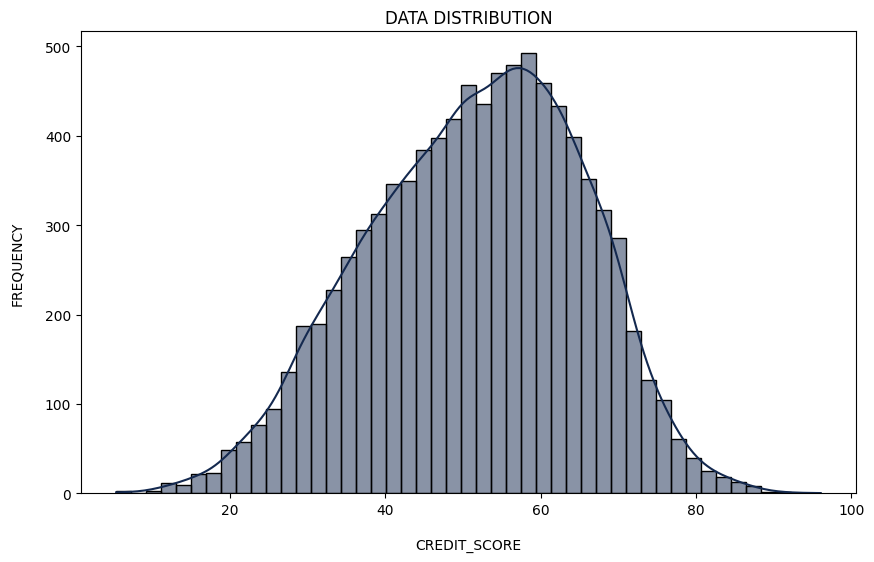

In [20]:
get_feature_distribution(rawData, 'CREDIT_SCORE', 'histogram', True)



Tabular representation:

OUTCOME         Considered for Quote  Denied Quote  Need Evaluation
VEHICLE_OWNERS                                                     
0                               1757          1104              169
1                               1376          4774              820


 Graphical representation:


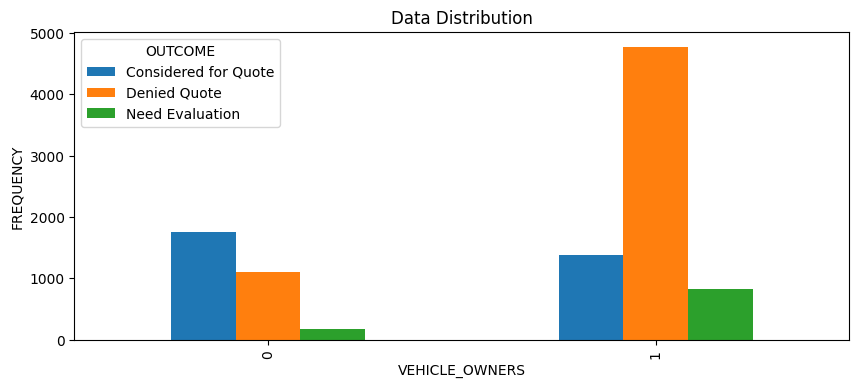

In [21]:
get_feature_distribution(rawData, 'VEHICLE_OWNERS', 'bar', True)



Tabular representation:

OUTCOME       Considered for Quote  Denied Quote  Need Evaluation
VEHICLE_YEAR                                                     
after 2015                     323          2304              406
before 2015                   2810          3574              583


 Graphical representation:


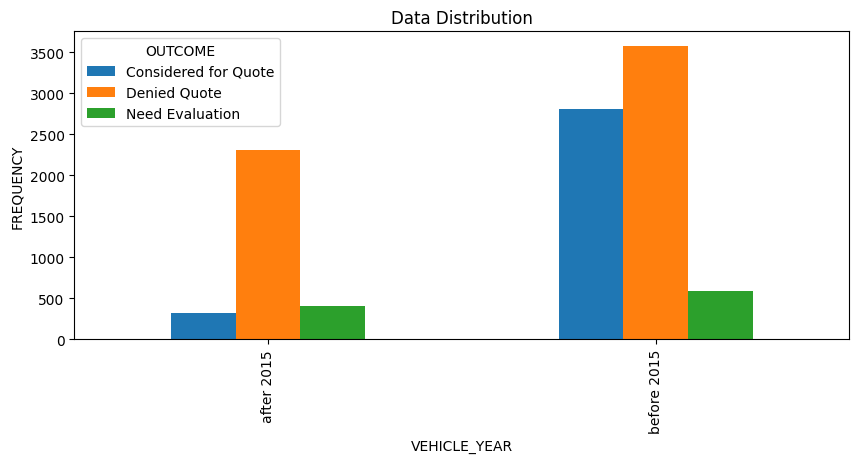

In [22]:
get_feature_distribution(rawData, 'VEHICLE_YEAR', 'bar', True)



Tabular representation:

OUTCOME         Considered for Quote  Denied Quote  Need Evaluation
MARITAL_STATUS                                                     
0                               2180          2543              295
1                                953          3335              694


 Graphical representation:


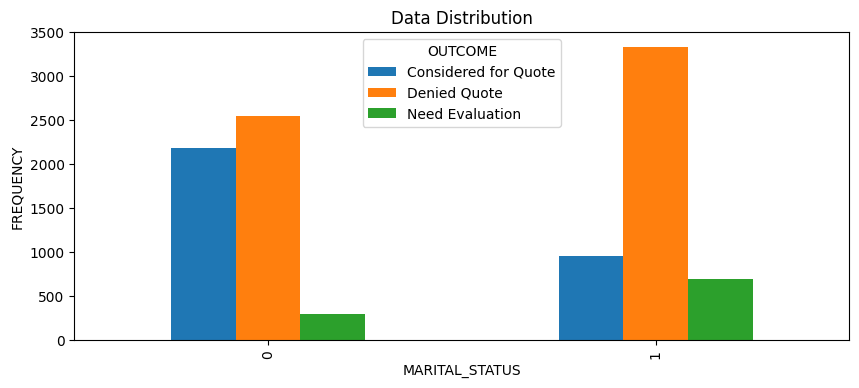

In [23]:
get_feature_distribution(rawData, 'MARITAL_STATUS', 'bar', True)



Tabular representation:

OUTCOME   Considered for Quote  Denied Quote  Need Evaluation
CHILDREN                                                     
0                         1475          1504              133
1                         1658          4374              856


 Graphical representation:


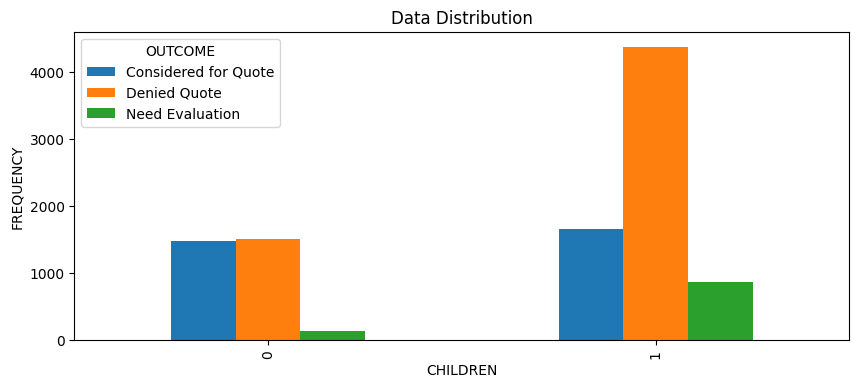

In [24]:
get_feature_distribution(rawData, 'CHILDREN', 'bar', True)



Tabular representation:

OUTCOME      Considered for Quote  Denied Quote  Need Evaluation
POSTAL_CODE                                                     
10238                        1886          4502              552
21217                         120             0                0
32765                         927          1121              408
92101                         200           255               29


 Graphical representation:


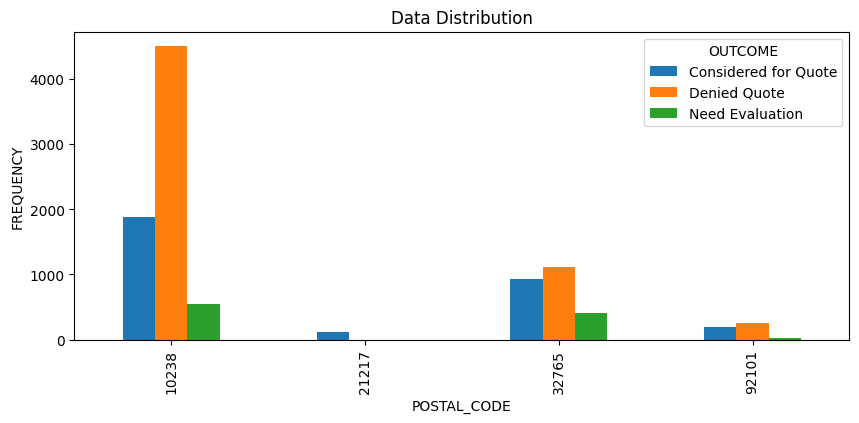

In [25]:
get_feature_distribution(rawData, 'POSTAL_CODE', 'bar', True)

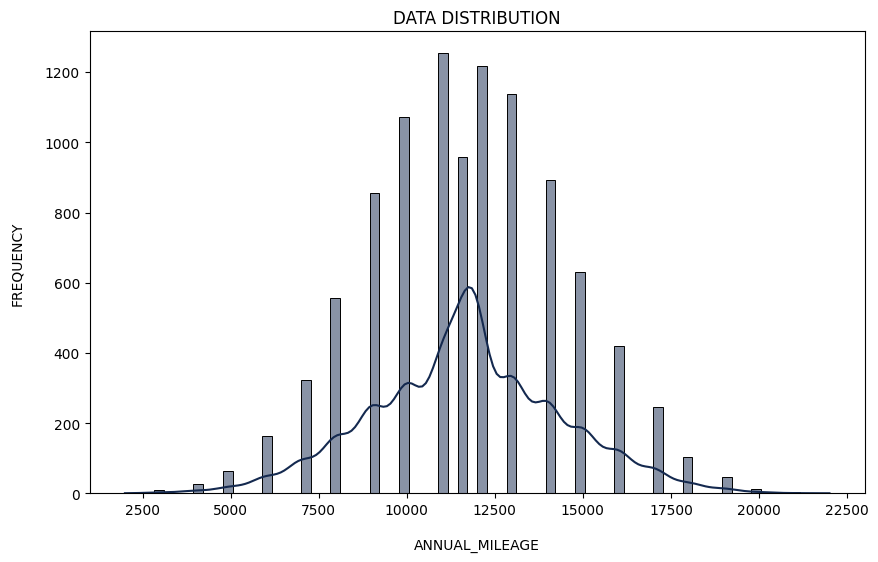

In [26]:
get_feature_distribution(rawData, 'ANNUAL_MILEAGE', 'histogram', True)



Tabular representation:

OUTCOME       Considered for Quote  Denied Quote  Need Evaluation
VEHICLE_TYPE                                                     
sedan                         2978          5602              943
sports car                     155           276               46


 Graphical representation:


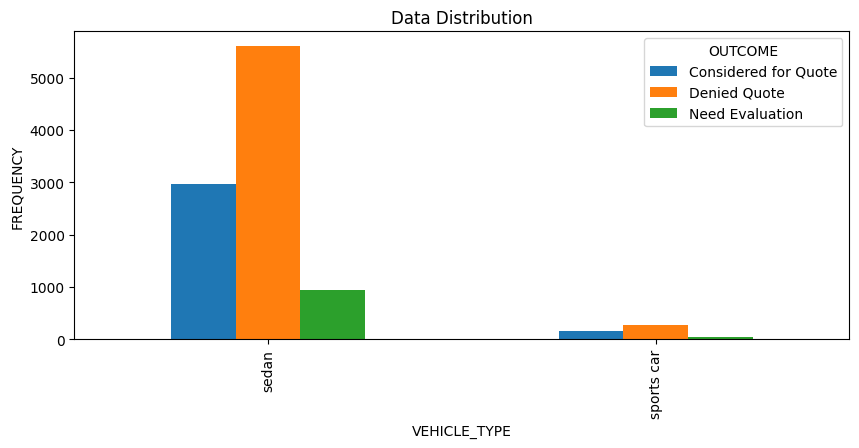

In [27]:
get_feature_distribution(rawData, 'VEHICLE_TYPE', 'bar', True)

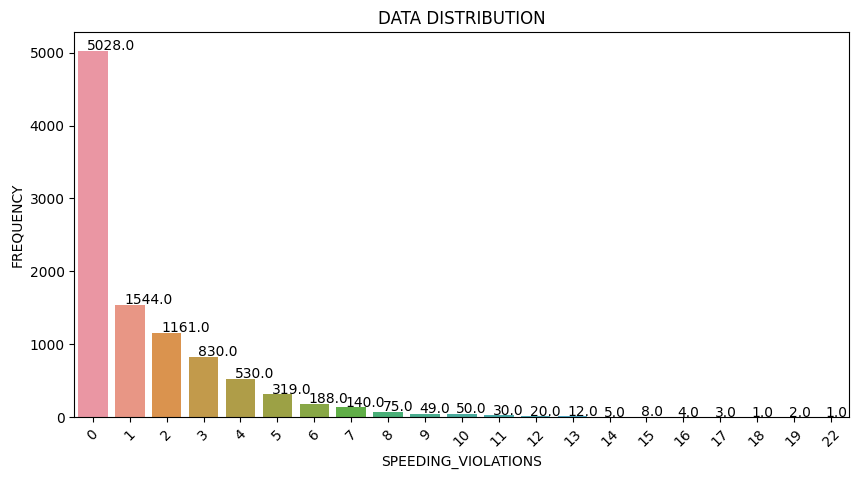

In [28]:
get_feature_distribution(rawData, 'SPEEDING_VIOLATIONS', 'count', True)

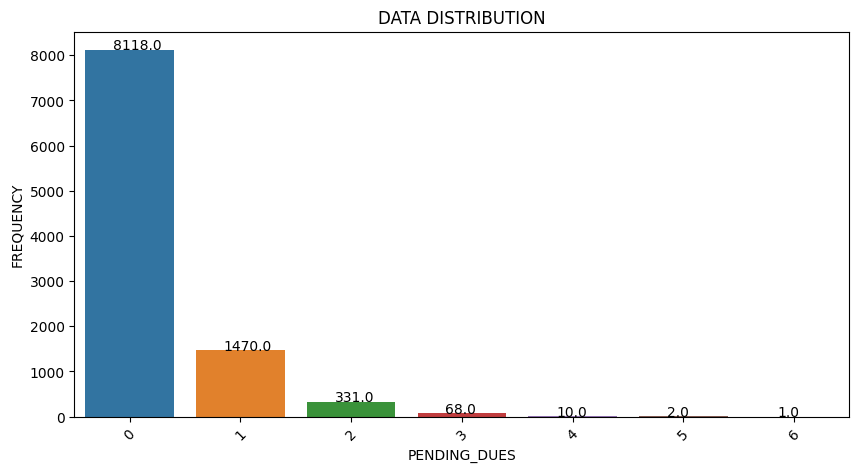

In [30]:
get_feature_distribution(rawData, 'PENDING_DUES', 'count', True)

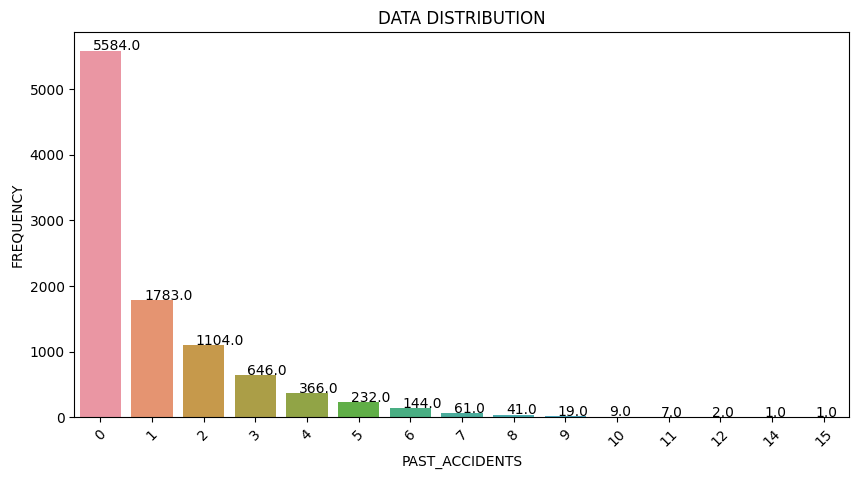

In [31]:
get_feature_distribution(rawData, 'PAST_ACCIDENTS', 'count', True)

<h4> Outlier Analysis </h4>

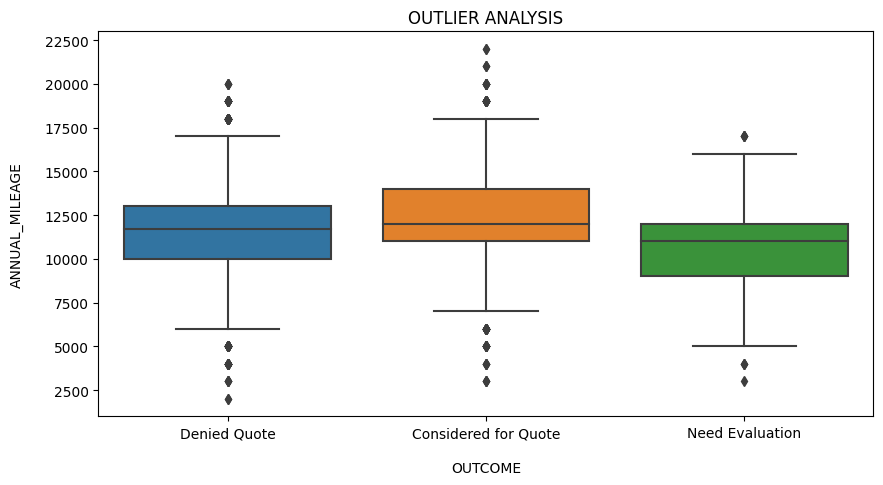

In [34]:
get_feature_distribution(rawData, 'ANNUAL_MILEAGE', 'box', True)

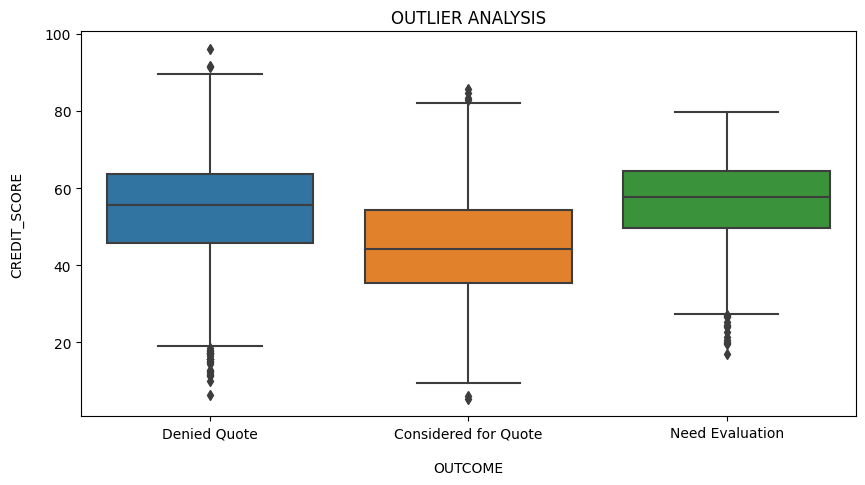

In [35]:
get_feature_distribution(rawData, 'CREDIT_SCORE', 'box', True)

<h4> Target Analysis </h4>

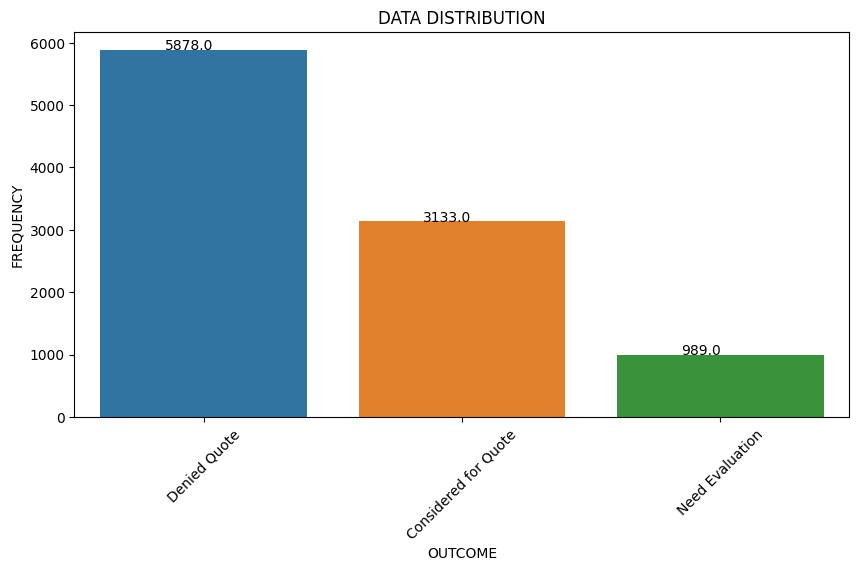

In [36]:
get_feature_distribution(rawData, 'OUTCOME', 'count', True)

<h3> Data Pre-Processing in real-time</h3>

<h4> Constants </h4>

In [37]:
ksql = 'http://192.168.1.9:8088'
broker = '192.168.1.9:29092'
sourceTopic = 'Submissions'
targetTopic = 'TRANSFORMEDSUBMISSIONS'

In [38]:
producer = KafkaProducer(bootstrap_servers=[broker],value_serializer=lambda x: dumps(x).encode('utf-8'))
client = KafkaAdminClient(bootstrap_servers=broker)
ksqlClient = KSQLAPI(ksql)

In [39]:
def handler(signum, frame):
    msg = "CTRL+C was pressed. Do you want to stop generating data - y/n : "
    print(msg, end="", flush=True)
    res = readchar.readchar()
    if res == "y":
        print("")
        exit(1)

<h5> Sending the data to the Kafka Topic </h5>

In [40]:
ksqlClient.ksql('show topics;')

[{'@type': 'kafka_topics',
  'statementText': 'show topics;',
  'topics': [{'name': 'default_ksql_processing_log', 'replicaInfo': [1]}],
  'warnings': []}]

In [41]:
%%time
pcnt = 0
for index, raw in rawData.iterrows():
    pcnt = pcnt+1
    rawjson = {
        'stream_id' : index,
        'created_timestamp' : datetime.now().strftime('%m%d%H%M%S%f'),
        'submission_id' : raw['SUBMISSION_ID'],
        'age' : raw['AGE'],
        'gender' : raw['GENDER'],
        'race' : raw['RACE'],
        'driving_exp' : raw['DRIVING_EXPERIENCE'],
        'education' : raw['EDUCATION'],
        'income_type' : raw['INCOME_TYPE'],
        'credit_score' : raw['CREDIT_SCORE'],
        'vehicle_owners' : raw['VEHICLE_OWNERS'],
        'vehicle_year' : raw['VEHICLE_YEAR'],
        'marital_status' : raw['MARITAL_STATUS'],
        'children' : raw['CHILDREN'],
        'postal_code' : raw['POSTAL_CODE'],
        'annual_mileage' : raw['ANNUAL_MILEAGE'],
        'vehicle_type' : raw['VEHICLE_TYPE'],
        'speeding_violations' : raw['SPEEDING_VIOLATIONS'],
        'pending_dues' : raw['PENDING_DUES'],
        'past_accidents' : raw['PAST_ACCIDENTS'],
        'outcome' : raw['OUTCOME']
    }
    time.sleep(0.01)
    producer.send(sourceTopic, rawjson)
    producer.flush()
    
producer.close()

CPU times: user 22.1 s, sys: 3.18 s, total: 25.3 s
Wall time: 2min 44s


<h5> Creating a raw data stream through kafka ksql database</h5>

In [42]:
ksqlClient.ksql('show topics;')

[{'@type': 'kafka_topics',
  'statementText': 'show topics;',
  'topics': [{'name': 'Submissions', 'replicaInfo': [1]},
   {'name': 'default_ksql_processing_log', 'replicaInfo': [1]}],
  'warnings': []}]

In [43]:
ksqlClient.ksql('show streams;')

[{'@type': 'streams',
  'statementText': 'show streams;',
  'streams': [{'type': 'STREAM',
    'name': 'KSQL_PROCESSING_LOG',
    'topic': 'default_ksql_processing_log',
    'keyFormat': 'KAFKA',
    'valueFormat': 'JSON',
    'isWindowed': False}],
  'warnings': []}]

In [44]:
rawSubmissionsStream = f"CREATE OR REPLACE STREAM rawSubmissions (stream_id INT, created_timestamp STRING, submission_id STRING, age STRING, gender STRING, race STRING, driving_exp STRING, education STRING, income_type STRING, credit_score DOUBLE, vehicle_owners INT, vehicle_year STRING, marital_status INT, children INT, postal_code BIGINT, annual_mileage BIGINT, vehicle_type STRING, speeding_violations INT, pending_dues INT, past_accidents INT, outcome STRING ) WITH (value_format = 'JSON', kafka_topic='{sourceTopic}');"

In [45]:
ksqlClient.ksql(rawSubmissionsStream)

[{'@type': 'currentStatus',
  'statementText': "CREATE OR REPLACE STREAM RAWSUBMISSIONS (STREAM_ID INTEGER, CREATED_TIMESTAMP STRING, SUBMISSION_ID STRING, AGE STRING, GENDER STRING, RACE STRING, DRIVING_EXP STRING, EDUCATION STRING, INCOME_TYPE STRING, CREDIT_SCORE DOUBLE, VEHICLE_OWNERS INTEGER, VEHICLE_YEAR STRING, MARITAL_STATUS INTEGER, CHILDREN INTEGER, POSTAL_CODE BIGINT, ANNUAL_MILEAGE BIGINT, VEHICLE_TYPE STRING, SPEEDING_VIOLATIONS INTEGER, PENDING_DUES INTEGER, PAST_ACCIDENTS INTEGER, OUTCOME STRING) WITH (KAFKA_TOPIC='Submissions', KEY_FORMAT='KAFKA', VALUE_FORMAT='JSON');",
  'commandId': 'stream/`RAWSUBMISSIONS`/create',
  'commandStatus': {'status': 'SUCCESS',
   'message': 'Stream created',
   'queryId': None},
  'commandSequenceNumber': 2,
  'warnings': []}]

In [46]:
ksqlClient.ksql('show streams;')

[{'@type': 'streams',
  'statementText': 'show streams;',
  'streams': [{'type': 'STREAM',
    'name': 'RAWSUBMISSIONS',
    'topic': 'Submissions',
    'keyFormat': 'KAFKA',
    'valueFormat': 'JSON',
    'isWindowed': False},
   {'type': 'STREAM',
    'name': 'KSQL_PROCESSING_LOG',
    'topic': 'default_ksql_processing_log',
    'keyFormat': 'KAFKA',
    'valueFormat': 'JSON',
    'isWindowed': False}],
  'warnings': []}]

In [48]:
rawKafkaData = ksqlClient.query('SELECT * FROM RAWSUBMISSIONS LIMIT 5;', use_http2=True)
for rdata in rawKafkaData: print(rdata)

{"queryId":"transient_RAWSUBMISSIONS_8362554473644115286","columnNames":["STREAM_ID","CREATED_TIMESTAMP","SUBMISSION_ID","AGE","GENDER","RACE","DRIVING_EXP","EDUCATION","INCOME_TYPE","CREDIT_SCORE","VEHICLE_OWNERS","VEHICLE_YEAR","MARITAL_STATUS","CHILDREN","POSTAL_CODE","ANNUAL_MILEAGE","VEHICLE_TYPE","SPEEDING_VIOLATIONS","PENDING_DUES","PAST_ACCIDENTS","OUTCOME"],"columnTypes":["INTEGER","STRING","STRING","STRING","STRING","STRING","STRING","STRING","STRING","DOUBLE","INTEGER","STRING","INTEGER","INTEGER","BIGINT","BIGINT","STRING","INTEGER","INTEGER","INTEGER","STRING"]}

[0,"0826102052554885","569520","65+","female","majority","0-9y","high school","upper class",62.9,1,"after 2015",0,1,10238,12000,"sedan",0,0,0,"Denied Quote"]

[1,"0826102052765433","750365","16-25","male","majority","0-9y","none","poverty",35.78,0,"before 2015",0,0,10238,16000,"sedan",0,0,0,"Considered for Quote"]

[2,"0826102052780809","199901","16-25","female","majority","0-9y","high school","working class",49.3

<h5> Creating a transformed data stream through kafka ksql database</h5>

In [49]:
transformSubmissionsQ = "CREATE OR REPLACE STREAM TRANSFORMEDSUBMISSIONS AS SELECT stream_id, MASK_KEEP_RIGHT(submission_id,4) AS submission_id, CASE WHEN age='16-25' THEN '0' WHEN age='26-39' THEN '1' WHEN age='40-64' THEN '2' ELSE '3' END AS age, CASE WHEN gender='male' THEN '1' ELSE '0' END AS gender, CASE WHEN race='majority' THEN '1' ELSE '0' END AS race, CASE WHEN driving_exp='0-9y' THEN '0' WHEN driving_exp='10-19y' THEN '1' WHEN driving_exp='20-29y' THEN '2' ELSE '3' END AS driving_exp, CASE WHEN education='none' THEN '0' WHEN education='high school' THEN '1' ELSE '2' END AS education, CASE WHEN income_type='poverty' THEN '0' WHEN income_type='working class' THEN '1' WHEN income_type='middle class' THEN '2' ELSE '3' END AS income_type, credit_score, vehicle_owners, CASE WHEN vehicle_year='after 2015' THEN '1' ELSE '0' END AS vehicle_year, marital_status, children, postal_code, annual_mileage, CASE WHEN vehicle_type='sedan' THEN '0' ELSE '1' END AS vehicle_type, speeding_violations, pending_dues, past_accidents, outcome FROM RAWSUBMISSIONS;"

In [50]:
kurl = ksql+'/ksql'
print(kurl)
jsbody = {
    "ksql" : transformSubmissionsQ,
    "streamsProperties" : {"ksql.streams.auto.offset.reset": "earliest"}
}

http://192.168.1.9:8088/ksql


In [51]:
res = requests.post(url=kurl,json = jsbody)
print(res.text)

[{"@type":"currentStatus","statementText":"CREATE OR REPLACE STREAM TRANSFORMEDSUBMISSIONS WITH (KAFKA_TOPIC='TRANSFORMEDSUBMISSIONS', PARTITIONS=1, REPLICAS=1) AS SELECT\n  RAWSUBMISSIONS.STREAM_ID STREAM_ID,\n  MASK_KEEP_RIGHT(RAWSUBMISSIONS.SUBMISSION_ID, 4) SUBMISSION_ID,\n  (CASE WHEN (RAWSUBMISSIONS.AGE = '16-25') THEN '0' WHEN (RAWSUBMISSIONS.AGE = '26-39') THEN '1' WHEN (RAWSUBMISSIONS.AGE = '40-64') THEN '2' ELSE '3' END) AGE,\n  (CASE WHEN (RAWSUBMISSIONS.GENDER = 'male') THEN '1' ELSE '0' END) GENDER,\n  (CASE WHEN (RAWSUBMISSIONS.RACE = 'majority') THEN '1' ELSE '0' END) RACE,\n  (CASE WHEN (RAWSUBMISSIONS.DRIVING_EXP = '0-9y') THEN '0' WHEN (RAWSUBMISSIONS.DRIVING_EXP = '10-19y') THEN '1' WHEN (RAWSUBMISSIONS.DRIVING_EXP = '20-29y') THEN '2' ELSE '3' END) DRIVING_EXP,\n  (CASE WHEN (RAWSUBMISSIONS.EDUCATION = 'none') THEN '0' WHEN (RAWSUBMISSIONS.EDUCATION = 'high school') THEN '1' ELSE '2' END) EDUCATION,\n  (CASE WHEN (RAWSUBMISSIONS.INCOME_TYPE = 'poverty') THEN '0' WHE

In [53]:
ksqlClient.ksql('show streams;')

[{'@type': 'streams',
  'statementText': 'show streams;',
  'streams': [{'type': 'STREAM',
    'name': 'TRANSFORMEDSUBMISSIONS',
    'topic': 'TRANSFORMEDSUBMISSIONS',
    'keyFormat': 'KAFKA',
    'valueFormat': 'JSON',
    'isWindowed': False},
   {'type': 'STREAM',
    'name': 'RAWSUBMISSIONS',
    'topic': 'Submissions',
    'keyFormat': 'KAFKA',
    'valueFormat': 'JSON',
    'isWindowed': False},
   {'type': 'STREAM',
    'name': 'KSQL_PROCESSING_LOG',
    'topic': 'default_ksql_processing_log',
    'keyFormat': 'KAFKA',
    'valueFormat': 'JSON',
    'isWindowed': False}],
  'warnings': []}]

In [54]:
transformedKafkaData = ksqlClient.query('SELECT * FROM TRANSFORMEDSUBMISSIONS LIMIT 5;', use_http2=True)
for tdata in transformedKafkaData: print(tdata)

{"queryId":"transient_TRANSFORMEDSUBMISSIONS_8535883183648392265","columnNames":["STREAM_ID","SUBMISSION_ID","AGE","GENDER","RACE","DRIVING_EXP","EDUCATION","INCOME_TYPE","CREDIT_SCORE","VEHICLE_OWNERS","VEHICLE_YEAR","MARITAL_STATUS","CHILDREN","POSTAL_CODE","ANNUAL_MILEAGE","VEHICLE_TYPE","SPEEDING_VIOLATIONS","PENDING_DUES","PAST_ACCIDENTS","OUTCOME"],"columnTypes":["INTEGER","STRING","STRING","STRING","STRING","STRING","STRING","STRING","DOUBLE","INTEGER","STRING","INTEGER","INTEGER","BIGINT","BIGINT","STRING","INTEGER","INTEGER","INTEGER","STRING"]}

[0,"nn9520","3","0","1","0","1","3",62.9,1,"1",0,1,10238,12000,"0",0,0,0,"Denied Quote"]

[1,"nn0365","0","1","1","0","0","0",35.78,0,"0",0,0,10238,16000,"0",0,0,0,"Considered for Quote"]

[2,"nn9901","0","0","1","0","1","1",49.31,1,"0",0,0,10238,11000,"0",0,0,0,"Denied Quote"]

[3,"nn8866","0","1","1","0","2","1",20.6,1,"0",0,1,32765,11000,"0",0,0,0,"Denied Quote"]

[4,"nn1664","1","1","1","1","0","1",38.84,1,"0",0,0,32765,12000,"0",

<h5> Consuming transformed data stream through kafka consumer</h5>

In [55]:
consumer = KafkaConsumer(targetTopic,bootstrap_servers=[broker],max_poll_records = 10000, max_poll_interval_ms = 3000000, consumer_timeout_ms = 1000, enable_auto_commit=True, auto_offset_reset = 'earliest', group_id='submissions-consumer', value_deserializer=lambda x: loads(x.decode('utf-8')))

In [56]:
print('Topics present for consumer : ', consumer.topics())
print('\n Topics subscribed by consumer for consuming data : ', consumer.subscription())

Topics present for consumer :  {'_schemas', 'TRANSFORMEDSUBMISSIONS', 'default_ksql_processing_log', 'Submissions', '_confluent-ksql-default__command_topic'}

 Topics subscribed by consumer for consuming data :  {'TRANSFORMEDSUBMISSIONS'}


In [57]:
%%time
warnings.filterwarnings("ignore")
transformedDF = pd.DataFrame()
counter=0
for message in consumer :
    counter = counter+1
    gc.collect()
    transformed_dict = {
        'submission_id' : message.value['SUBMISSION_ID'],
        'stream_id' : message.value['STREAM_ID'],
        'age' : message.value['AGE'],
        'gender' : message.value['GENDER'],
        'race' : message.value['RACE'],
        'driving_exp' : message.value['DRIVING_EXP'],
        'education' : message.value['EDUCATION'],
        'income_type' : message.value['INCOME_TYPE'],
        'credit_score' : message.value['CREDIT_SCORE'],
        'vehicle_owners' : message.value['VEHICLE_OWNERS'],
        'vehicle_year' : message.value['VEHICLE_YEAR'],
        'marital_status' : message.value['MARITAL_STATUS'],
        'children' : message.value['CHILDREN'],
        'postal_code' : message.value['POSTAL_CODE'],
        'annual_mileage' : message.value['ANNUAL_MILEAGE'],
        'vehicle_type' : message.value['VEHICLE_TYPE'],
        'speeding_violations' : message.value['SPEEDING_VIOLATIONS'],
        'pending_dues' : message.value['PENDING_DUES'],
        'past_accidents' : message.value['PAST_ACCIDENTS'],
        'outcome' : message.value['OUTCOME']
     }
    transformedDF = transformedDF.append(transformed_dict, ignore_index = True)
    if counter==5000:
        print('Loaded 5000 records')
consumer.close()

Loaded 5000 records
CPU times: user 9min 25s, sys: 12.6 s, total: 9min 37s
Wall time: 9min 58s


<h3> Storing data in parquet</h3>

In [58]:
todaydate = datetime.now().strftime('%Y%m%d%H%M%S')
file_name = str(todaydate)+'-submission-data.parquet'
print(file_name)

20230826103953-submission-data.parquet


In [59]:
transformedDF.to_parquet(file_name, index = False, engine = 'auto')

In [60]:
transformedDF.head(5)

,submission_id,stream_id,age,gender,race,driving_exp,education,income_type,credit_score,vehicle_owners,vehicle_year,marital_status,children,postal_code,annual_mileage,vehicle_type,speeding_violations,pending_dues,past_accidents,outcome
0,nn9520,0,3,0,1,0,1,3,62.90,1,1,0,1,10238,12000,0,0,0,0,Denied Quote
1,nn0365,1,0,1,1,0,0,0,35.78,0,0,0,0,10238,16000,0,0,0,0,Considered for Quote
2,nn9901,2,0,0,1,0,1,1,49.31,1,0,0,0,10238,11000,0,0,0,0,Denied Quote
3,nn8866,3,0,1,1,0,2,1,20.60,1,0,0,1,32765,11000,0,0,0,0,Denied Quote
4,nn1664,4,1,1,1,1,0,1,38.84,1,0,0,0,32765,12000,0,2,0,1,Considered for Quote


<h3> Data Preparation </h3>

<h4> Upsampling of Target for avoiding overfitting </h4>

In [61]:
upsampDF = up_sample_training_dataset(transformedDF,'outcome')

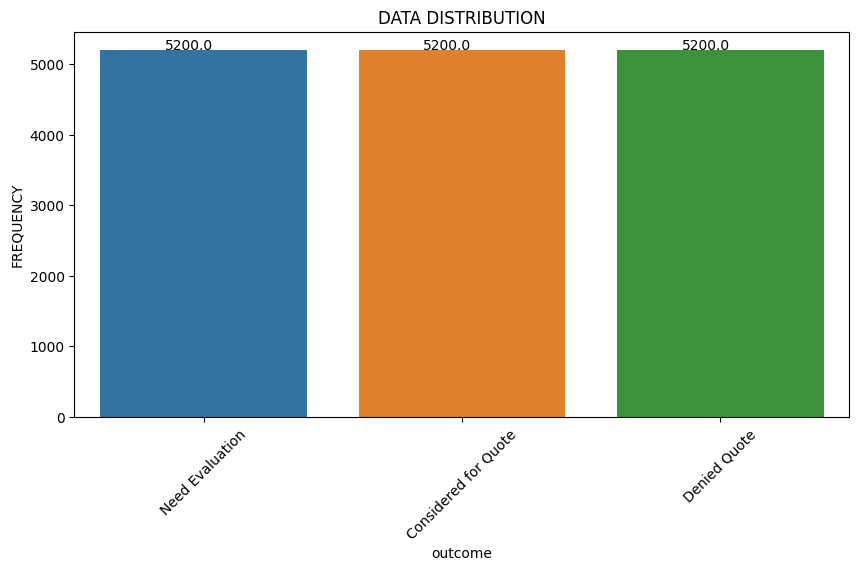

In [62]:
get_feature_distribution(upsampDF,'outcome','count',True)

In [63]:
upsampDF.replace('Need Evaluation',2,inplace=True)
upsampDF.replace('Considered for Quote',1,inplace=True)
upsampDF.replace('Denied Quote',0,inplace=True)

In [64]:
upsampDF.head(5)

,submission_id,stream_id,age,gender,race,driving_exp,education,income_type,credit_score,vehicle_owners,vehicle_year,marital_status,children,postal_code,annual_mileage,vehicle_type,speeding_violations,pending_dues,past_accidents,outcome
0,nn3414,1125,3,0,1,3,2,3,48.69,1,0,0,1,32765,12000,0,3,1,0,2
1,nn6688,4287,2,1,1,2,2,3,58.63,1,0,1,1,32765,10000,0,10,2,3,2
2,nn6662,8570,2,1,1,2,1,1,34.23,1,0,0,1,10238,12000,0,2,1,5,2
3,nn0138,2727,3,0,1,2,2,3,68.67,1,0,1,1,32765,7000,0,3,1,1,2
4,nn0638,1148,3,1,1,2,1,3,60.08,1,1,0,1,10238,7000,0,2,1,0,2


<h4> Feature Extraction</h4>

<h5> Dimensionality reduction </h5>

In [65]:
upsampDF.drop("submission_id", axis=1, inplace = True)
upsampDF.drop("stream_id", axis=1, inplace = True)

In [66]:
upsampDF.head(5)

,age,gender,race,driving_exp,education,income_type,credit_score,vehicle_owners,vehicle_year,marital_status,children,postal_code,annual_mileage,vehicle_type,speeding_violations,pending_dues,past_accidents,outcome
0,3,0,1,3,2,3,48.69,1,0,0,1,32765,12000,0,3,1,0,2
1,2,1,1,2,2,3,58.63,1,0,1,1,32765,10000,0,10,2,3,2
2,2,1,1,2,1,1,34.23,1,0,0,1,10238,12000,0,2,1,5,2
3,3,0,1,2,2,3,68.67,1,0,1,1,32765,7000,0,3,1,1,2
4,3,1,1,2,1,3,60.08,1,1,0,1,10238,7000,0,2,1,0,2


<h5> Feature Importance </h5>

[0.04575477 0.02595522 0.01045503 0.15443862 0.02663193 0.05827687
 0.08342552 0.04738033 0.03482794 0.01917743 0.01817975 0.04110815
 0.06073182 0.00798507 0.07034374 0.25753974 0.03778809]


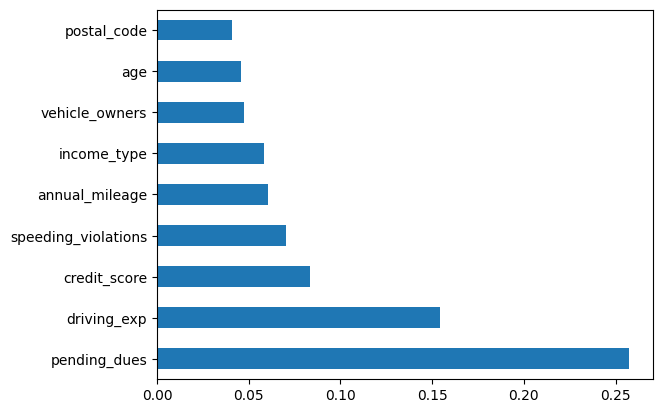

In [67]:
# Feature Importance with Extra Trees Classifier
X = upsampDF.drop("outcome", axis=1)
Y = upsampDF["outcome"]
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)
ft_importances = pd.Series(model.feature_importances_, index=X.columns)
ft_importances.nlargest(9).plot(kind='barh')
plt.show()

<h4> Data Splitting </h4>

In [68]:
copiedDF = upsampDF.copy()

In [69]:
# Collect Training Data
X = copiedDF[['pending_dues','driving_exp','speeding_violations','credit_score','annual_mileage','age','vehicle_owners','income_type','postal_code']]
y = copiedDF['outcome'].values

In [70]:
# Split the data into train (70%), test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True, stratify = y)

<h4> Data Standardisation </h4>

In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# X_val_scaled = scaler.fit_transform(X_val)

<h4> Model Building </h4>

<h5> Training the model </h5>

In [72]:
# Train a Probabilistic Classification Model
model = LogisticRegression(C = 0.75, penalty = 'l1', random_state = 0, solver = 'saga', multi_class='multinomial', max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.75, max_iter=1000, multi_class='multinomial',
                   penalty='l1', random_state=0, solver='saga')

<h5> Prediction of model </h5>

In [73]:
# Predict the classes on the validation set
y_test_pred = model.predict(X_test_scaled)

<h5> Performance of model based on F1 score and accuracy</h5>

In [74]:
# Calculate F1 score for validation set
f1_test = f1_score(y_test, y_test_pred, average='weighted')

In [75]:
# Print F1 score for validation set
print("F1 Score (Validation):", f1_test)

F1 Score (Validation): 0.8120922148795992


In [76]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.67      0.73      1560
           1       0.75      0.81      0.78      1560
           2       0.88      0.97      0.92      1560

    accuracy                           0.82      4680
   macro avg       0.82      0.82      0.81      4680
weighted avg       0.82      0.82      0.81      4680



<h5> Performance via ROC Graph </h5>

In [77]:
# Calculate predicted probabilities for ROC AUC curve
y_probs = model.predict_proba(X_test_scaled)
roc_auc = dict()
for i in range(len(model.classes_)):
    roc_auc[i] = roc_auc_score((y_test == model.classes_[i]).astype(int), y_probs[:, i])

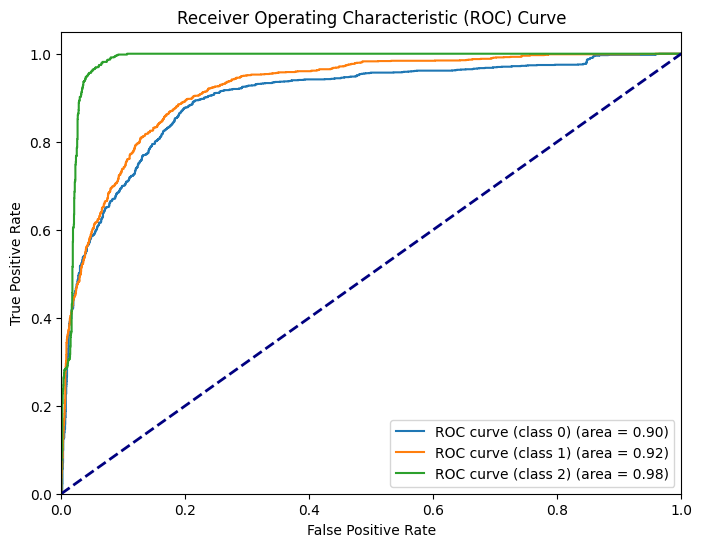

In [78]:
# Plot ROC AUC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    fpr, tpr, _ = roc_curve((y_test == model.classes_[i]).astype(int), y_probs[:, i])
    plt.plot(fpr, tpr, label='ROC curve (class {}) (area = {:.2f})'.format(model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()